In [1]:
import statsmodels.api as sm
import statsmodels.stats as stats
import scipy
from sklearn import linear_model
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.sm_exceptions import DomainWarning, PerfectSeparationWarning
import warnings
from patsy import dmatrix, dmatrices
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy import stats
from tabulate import tabulate
import glob
import itertools
import os
import pickle as pkl

pd.set_option('display.precision', 3)
pd.options.mode.chained_assignment = None

In [3]:
age_of_puberty = {
        "Human": 13, "Baboon": 5.4, "Aye_aye": 3, "Chimpanzee": 14,
        "Rhesus_macaque": 3.5, "Owl_monkey": 1, "Mouse": 0.15,
        "Cat": 0.5,
}

generation_time = {"Baboon": 10, "Human": 29, "Aye_aye": 4, 
        "Rhesus_macaque": 8, "Mouse": 0.75, "Owl_monkey": 6.6, "Chimpanzee": 25, "Cat": 3.8, 
}

paternal_maternal_ratio = {"Human": [1.516207, 0.4185496], "Baboon": [0.9241126, 0], "Aye_aye": [0.6805108, 2.45706], 
        "Rhesus_macaque": [1.664385, 0.2539662], "Mouse": [6.618493, 0], "Owl_monkey": [1.824674, 0], "Chimpanzee": [4.23242, 0.2456793], "Cat": [1.632583, 0.003037378],
}

## Poisson regression, bootstrap implementation for single species, and other helper functions

In [4]:
def poisson_regression_for_individual_species(y, X, print_result=False, add_intercept=False):
    X = sm.add_constant(X) if add_intercept else X
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DomainWarning)
        result = sm.GLM(y, X, family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
        
    params, pvals, conf_int = result.params, result.pvalues, result.conf_int()
    intercept_params_name, slope_params_name = X.columns
    conf_int.columns = ["lower", "upper"]
    df_result = pd.concat([params.rename("coeff"), pvals.rename("pval"), conf_int], axis=1)
    if print_result:
        print(df_result)
    return [params[intercept_params_name], params[slope_params_name], df_result, result]

def plot_poisson_regression_result(df, params, title):
    mu_per_site = df["mutation_count"] / df["callable_genome_size"]
    paternal_age = df["paternal_age"]
    max_paternal_age = np.max(paternal_age)
    intercept = params[0]
    slope = params[1]
    line_x, line_y = [0, max_paternal_age], [intercept, intercept + slope * max_paternal_age]
    fig, ax = plt.subplots(1, 1)
    ax.scatter(paternal_age, mu_per_site)
    ax.plot(line_x, line_y)
    ax.set_title(title)
    
def compute_weighted_average_age_and_regression_covariates(paternal_age, maternal_age, callable_genome_size, age_of_puberty, paternal_maternal_ratio = [3, 1]):
    paternal_coeff, maternal_coeff = paternal_maternal_ratio
    denominator = np.sum(paternal_maternal_ratio)
    corrected_age = (paternal_coeff * paternal_age + maternal_coeff * maternal_age) / denominator - age_of_puberty

    Z_p = paternal_age * callable_genome_size
    Z_m = maternal_age * callable_genome_size
    Z_c = corrected_age * callable_genome_size
    return [corrected_age, Z_p, Z_m, Z_c]

def calculate_nested_f_statistic(small_model, big_model):
    """
        Given two fitted GLMs, the larger of which contains the parameter space of the smaller, 
        return the F Stat and P value corresponding to the larger model adding explanatory power
        from link: https://stackoverflow.com/questions/27328623/anova-test-for-glm-in-python
    """
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

def check_batch_effect(df_dict):
    """ 
    helper function that performs joint and individual regressions for species where multiple datasets are available,
    also performs categorical regression by setting datasets as a categorical variable
    """
    data_list = []
    for dataset, df_subset in df_dict.items():
        df_subset["dataset"] = dataset
        data_list.append(df_subset)
        y, X = df_subset["mutation_count"], df_subset[["callable_genome_size", "Z_c"]]
        print(f"\n--------------- Dataset: {dataset}, {len(df_subset)} individuals --------------------")
        _ = poisson_regression_for_individual_species(y.astype(float), X.astype(float), print_result=True, add_intercept=False)
    df = pd.concat(data_list, ignore_index=True)

    y, X = df["mutation_count"], df[["callable_genome_size", "Z_c"]]
    print(f"\n--------------- joint regression, {len(df)} individuals --------------------")
    _, _, _, result_joint = poisson_regression_for_individual_species(y.astype(float), X.astype(float), print_result=True, add_intercept=False)

    print(f"\n----------- Dataset as categories regression -------------")
    X = dmatrix(f"0 + callable_genome_size + Z_c + C(dataset):callable_genome_size + C(dataset):Z_c", df)
    column_names = X.design_info.column_names
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DomainWarning)
        result_category = sm.GLM(y.astype(float), X.astype(float), family=sm.families.Poisson(link=sm.genmod.families.links.Identity())).fit()
    params, pvals, conf_int = list(result_category.params), list(result_category.pvalues), result_category.conf_int()
    table = [["coeff"] + params, ["p-value"] + pvals]
    
    _, p_val_batch = calculate_nested_f_statistic(result_joint, result_category)
    print(f"the p-value from the ANOVA test for batch effect is {p_val_batch}")
    
    df_column_names = ["intercept", "dataset x interaction", "slope", "dataset x slope interaction", "p_val_intercept", "p_val_dataset x interaction", "p_val_slope", "p_val_dataset x slope interaction"]
    result = [params + pvals]
    df_batch_effect = pd.DataFrame(result, columns=df_column_names)
    df_batch_effect["p_val_anova"] = p_val_batch
    dataset_name_str = " vs ".join([k for k in df_dict.keys()]) 
    df_batch_effect.index = [dataset_name_str]
    df_batch_effect.to_csv(f"output/batch_effect_results/batch_effect_{dataset_name_str}.csv")
    
    # df_batch_output
    print(tabulate(table, headers=column_names))

## Load data from different species

### Load Wu 2020 baboon and human data, and Wang 2024 baboon data

In [5]:
def group_rows_wu_2020_helper(df, genome_size, species_name, age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results):
    output_dict = defaultdict(dict)
    for idx, row in df.iterrows():
        individual = row["F1"]
        if row["Parent"] == "Pat":
            output_dict[individual]["paternal_age"] = row["age"]
            output_dict[individual]["paternal_count"] = row["dnm"]
        elif row["Parent"] == "Mat":
            output_dict[individual]["maternal_age"] = row["age"]
            output_dict[individual]["maternal_count"] = row["dnm"]
    maternal_missing = [] 
    for individual, val in output_dict.items():
        val["individual"] = individual
        if "maternal_count" not in val:
            maternal_missing.append(individual)
            continue
        val["mutation_count"] = val["paternal_count"] + val["maternal_count"]
    if print_quality_check_results:
        print(f"there are {len(maternal_missing)} {species_name} missing maternal count")


    # mu_site_gen_human = mu_site_gen_human = compute_average_per_generation_per_site_mutation_rate(
    #     human_genome_size, df_human_group, paternal_gen_time_human, maternal_gen_time_human)
    # print(f"average mutation rate per site per generation for humans is {np.mean(mu_site_gen_human)}")
    for m in maternal_missing:
        _ = output_dict.pop(m)
    df_group = pd.DataFrame(output_dict.values())
    df_group["callable_genome_size"] = genome_size
    df_group["species"] = species_name
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df_group["corrected_age"], df_group["Z_p"], df_group["Z_m"], df_group["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df_group["paternal_age"].to_numpy(), df_group["maternal_age"].to_numpy(), df_group["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha)
    return df_group[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def compute_average_per_generation_per_site_mutation_rate(genome_size, df, paternal_generation_time, maternal_generation_time):
    paternal_count, maternal_count = df["paternal_count"].to_numpy(), df["maternal_count"].to_numpy()
    paternal_age, maternal_age = df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy()
    paternal_rate_per_site_per_gen = paternal_count / paternal_age * paternal_generation_time / genome_size
    maternal_rate_per_site_per_gen = maternal_count / maternal_age * maternal_generation_time / genome_size
    mutation_rate_per_site_per_gen = (paternal_rate_per_site_per_gen + maternal_rate_per_site_per_gen) / 2
    return mutation_rate_per_site_per_gen

def load_baboon_human_wu_2020_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False):
    filename = "./data/mutation_rate_individual_species/baboon_wu_2020/baboon_wu_2020_S2_data.xlsx"
    human_genome_size, baboon_genome_size = 2*2881033286, 2*2581196250
    age_of_puberty_human, age_of_puberty_baboon = age_of_puberty["Human"], age_of_puberty["Baboon"]
    paternal_gen_time_human, maternal_gen_time_human = 32, 28.2
    paternal_gen_time_baboon, maternal_gen_time_baboon = 10.7, 10.2


    df_human = pd.read_excel(filename, sheet_name="Fig 2A", skiprows=[0], nrows=21)
    df_human_group = group_rows_wu_2020_helper(df_human, human_genome_size, "Human", age_of_puberty_human, use_default_alpha, paternal_maternal_ratio["Human"], print_quality_check_results)

    df_baboon = pd.read_excel(filename, sheet_name="Fig 2B", skiprows=[0], nrows=23)
    df_baboon_group = group_rows_wu_2020_helper(df_baboon, baboon_genome_size, "Baboon", age_of_puberty_baboon, use_default_alpha, paternal_maternal_ratio["Baboon"], print_quality_check_results)

    return [df_human_group, df_baboon_group]

def load_baboon_wang_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False):
    filename = "./data/mutation_rate_individual_species/Baboon_Wang_2024.xlsx"
    age_of_puberty = age_of_puberty["Baboon"]
    df = pd.read_excel(filename, converters={"maternal_age": float, "paternal_age": float, "mutation_count": int})
    df["callable_genome_size"] = df["callable_genome_size"] * 1e9 * 2

    if print_quality_check_results:
        # print(df["mutation_count"] / df["callable_genome_size"])
        # print(df["mutation_rate"])
        print(f"average age of parents: {np.mean(df[['paternal_age', 'maternal_age']])}")
        print(f"average mutation rate: {np.mean(df['mutation_count'] / df['callable_genome_size'])}")
    # the rate column can be obtained by df["mutation_count"] / df["callable_genome_size"]
    df["species"] = "Baboon"
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha)
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

### Load Jonsson human data

In [6]:
def load_human_jonsson_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False):
    filename = "./data/mutation_rate_individual_species/Human_jonsson_2017.tsv"
    age_of_puberty_human = age_of_puberty["Human"]
    genome_size = 2682890000
    correction_factor = 1.009
    col_header = ["Proband_id", "is_discordant", "paternal_age", "maternal_age"]
    datatypes = {"Proband_id": str, "paternal_age": int, "maternal_age": int}
    # df_parental_age = df_parental_age.set_index("Individual")
    df_raw = pd.read_csv(filename, skiprows=[0], header=None, names=col_header, sep="\t", usecols=[4,5,6,7], dtype=datatypes)
    df_raw["Proband_id"] = df_raw["Proband_id"].apply(lambda x: int(x.split("-")[1]))
    discordant_mask = df_raw["is_discordant"] == "Discordant"
    # df_non_discordant = df_raw[~discordant_mask]
    df = df_raw.groupby(["Proband_id"]).agg(
        mutation_count=('Proband_id', 'count'), 
        paternal_age=('paternal_age', 'first'), 
        maternal_age=('maternal_age', 'first'))
    if print_quality_check_results:
        print(f"there are {len(df_raw)} variants called in the file")
        print(f"there are {np.sum(discordant_mask)} variants that are discordant")
        print(f"there are {len(df)} unique probands")
        print(f"average number of mutations per proband {np.mean(df['mutation_count'])}")
    df['mutation_count'] *= correction_factor
    df["callable_genome_size"] = genome_size * 2
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty_human, paternal_maternal_ratio=alpha
        )
    df["species"] = "Human"
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

### Load Chimpanzee data (Venn 2014, Besenbacher 2019)

In [7]:
def load_chimpanzee_venn_parental_age(print_quality_check_results=False):
    filename = "./data/mutation_rate_individual_species/Chimp_venn_2014.xlsx"
    df_parental_age = pd.read_excel(filename, sheet_name="parental_age_false_negative")
    
    df_parental_age = df_parental_age.set_index("Individual")
    df_parental_age[["paternal_age", "maternal_age"]] /= 365
    if print_quality_check_results:
        print(f"average paternal age: {np.mean(df_parental_age['paternal_age'])}")
        print(f"average maternal age: {np.mean(df_parental_age['maternal_age'])}")
    return df_parental_age

def load_chimpanzee_venn_2014_mutation_count(print_quality_check_results=False):
    filename = "./data/mutation_rate_individual_species/Chimp_venn_2014.xlsx"
    col_header = ["chr_num", "recipient", "is_validated", "is_suspicious"]
    df_counts = pd.read_excel(filename, skiprows=[0,1], header=None, names=col_header, usecols=[0,7,10,11])
    df_counts = df_counts[df_counts["chr_num"] != "chrX"] # 220 total mutations, 217 on autosomes
    df_counts = df_counts.dropna()
    df_counts_ns = df_counts[df_counts["is_suspicious"] == 0]
    df_counts_unique = df_counts_ns["recipient"].value_counts()
    assert np.sum(df_counts_unique) == len(df_counts_ns)
    if print_quality_check_results:
        print(f"number of variants on autosomes: {len(df_counts)}, number of suspicious variants: {len(df_counts[df_counts['is_suspicious'] == 1])}")
        print(f"average number of mutations: {np.mean(df_counts_unique)}")
        # 60 validated, paper says 61, 1 of which is false positive, therefore probably all variants included in dataset are true positives  
        # print(df["is_validated"].value_counts()) 
    df_counts_unique = df_counts_unique.sort_index(axis=0, ascending=True)
    df_counts_unique.name = "mutation_count"
    return df_counts_unique

def load_chimpanzee_venn_2014_data(age_of_puberty, paternal_maternal_ratio=[3,1], print_quality_check_results=False):
    age_of_puberty = age_of_puberty["Chimpanzee"]
    genome_size = 2360347379

    df_parental_age = load_chimpanzee_venn_parental_age(print_quality_check_results)
    df_count = load_chimpanzee_venn_2014_mutation_count(print_quality_check_results)

    assert len(df_count) == len(df_parental_age)
    assert set(df_count.index) == set(df_parental_age.index)
    df = pd.merge(df_parental_age, df_count, left_index=True, right_index=True) #J, on="index")
    assert (df["mutation_count"] == df_count).all() 
    assert ((df[["paternal_age", "maternal_age"]] == df_parental_age[["paternal_age", "maternal_age"]]).all()).all()
    
    df["mutation_count"] /= (1 - df["FNR"])
    # false_negative_rate_F1 = 0.034
    # false_negative_rate_F2 = 0.23
    # df.loc[["D", "E", "F"], "mutation_count"] /= (1 - false_negative_rate_F1)
    # df.loc[["G", "H", "I"], "mutation_count"] /= (1 - false_negative_rate_F2)
    df["callable_genome_size"] = genome_size * 2
    df["species"] = "Chimpanzee"
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=paternal_maternal_ratio["Chimpanzee"]
        )
    df["mu_per_site"] = df["mutation_count"] / df["callable_genome_size"]
    df = df.reset_index()
    
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def load_besenbacher_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio):
    age_of_puberty = age_of_puberty["Chimpanzee"] # {"Chimpanzee": 14, "Gorilla":, "Orangutan":}
    filename = "./data/mutation_rate_individual_species/Great_ape_besenbacher_2019.txt"
    col_header = ["species", "paternal_age", "maternal_age", "callable_genome_size", "mutation_count", "mu_per_site"]
    df = pd.read_csv(filename, sep=" ", header=None, names=col_header, usecols=[1,2,3,4,5,9]) #, nrows=2)
    assert np.isclose(df["mutation_count"] / df["callable_genome_size"], df["mu_per_site"]).all()
    # currently only using chimpanzee
    df = df.loc[df["species"] == "Chimpanzee"]
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(),
        age_of_puberty, paternal_maternal_ratio=alpha
        )
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]


### Load Aye-aye data 

In [8]:
def update_sample_6_and_8_mutation_count(df):
    # 2 mutations shared by 6 and 8, line 21 and 194 in excel file
    df.loc[6] += 2
    df.loc[8] += 2
    assert df.loc[6] == 18
    assert df.loc[8] == 25
    df = df.drop("6,8")
    return df

def load_versoza_aye_aye_parental_age(filename):
    df_parental_age = pd.read_excel(filename, sheet_name="Table 1")
    name_map = {"sire's age at birth (in days)": "paternal_age", "dam's age at birth (in days)": "maternal_age"}
    df_parental_age.rename(columns=name_map, inplace=True)
    F1_offspring = [i for i in range(5, 12)]
    
    df_parental_age = df_parental_age.loc[df_parental_age["pedigree ID"].isin(F1_offspring)][["pedigree ID", "paternal_age", "maternal_age"]]
    df_parental_age = df_parental_age.set_index("pedigree ID")
    df_parental_age[["paternal_age", "maternal_age"]] /= 365
    df_parental_age["paternal_age"] = df_parental_age["paternal_age"].astype(float)
    df_parental_age["maternal_age"] = df_parental_age["maternal_age"].astype(float)
    return df_parental_age

def load_versoza_aye_aye_mutation_count(filename, print_quality_check_results):
    df_counts = pd.read_excel(filename, sheet_name="Table 3", skiprows=[1])
    if print_quality_check_results:
        print(f"there are in total {len(df_counts)} called mutations")
    df_counts_unique = df_counts["recipient"].value_counts()
    df_counts_unique = update_sample_6_and_8_mutation_count(df_counts_unique)
    df_counts_unique = df_counts_unique.sort_index(axis=0, ascending=True)
    df_counts_unique.name = "mutation_count"
    return df_counts_unique

def load_versoza_aye_aye_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False):
    filename = "./data/mutation_rate_individual_species/Ayeaye_Versoza_2024.xlsx"
    age_of_puberty = age_of_puberty["Aye_aye"]
    genome_size = 2279228391
    false_negative_rate = 0.095

    df_count = load_versoza_aye_aye_mutation_count(filename, print_quality_check_results)
    df_parental_age = load_versoza_aye_aye_parental_age(filename)
    assert len(df_count) == len(df_parental_age)
    assert set(df_count.index) == set(df_parental_age.index)
    df = pd.merge(df_parental_age, df_count, left_index=True, right_index=True) #J, on="index")
    assert (df["mutation_count"] == df_count).all() 
    assert ((df[["paternal_age", "maternal_age"]] == df_parental_age).all()).all()
    df["mutation_count"] /= (1 - false_negative_rate)

    df["callable_genome_size"] = genome_size * 2
    df["species"] = "Aye_aye"
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha
        )
    df["mu_per_site"] = df["mutation_count"] / df["callable_genome_size"]

    if print_quality_check_results:
        mu_min_idx, mu_max_idx, mu_mean = np.argmin(df["mu_per_site"]), np.argmax(df["mu_per_site"]), np.mean(df["mu_per_site"])
        for s, idx in [("minimum", mu_min_idx), ("maximum", mu_max_idx)]:
            m, pat, mat = df[["mu_per_site", "paternal_age", "maternal_age"]].iloc[idx]
            print(f"{s} mutation rate: {m:.2E}, maternal age: {mat:.1f}, paternal age: {pat:.1f}")
        print(f"mean mutation rate: {mu_mean:.2E}")
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def load_wang_aye_aye_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False):
    filename = "./data/mutation_rate_individual_species/Ayeaye_Wang_2024.xlsx"
    age_of_puberty = age_of_puberty["Aye_aye"]
    df = pd.read_excel(filename, converters={"maternal_age": float, "paternal_age": float, "mutation_count": int})
    df["callable_genome_size"] = df["callable_genome_size"] * 1e9 * 2

    if print_quality_check_results:
        print(f"average age of parents: {np.mean(df[['paternal_age', 'maternal_age']])}")
        print(f"average mutation rate: {np.mean(df['mutation_count'] / df['callable_genome_size'])}")
    # the rate column can be obtained by df["mutation_count"] / df["callable_genome_size"]
    df["species"] = "Aye_aye"
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio #paternal_maternal_ratio["Aye_aye"]
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha
    )
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

# df_v = load_versoza_aye_aye_data(age_of_puberty)
def plot_ayeaye_wang_parental_ages(age_of_puberty):
    df = load_wang_aye_aye_data(age_of_puberty, use_default_alpha=False)
    x_min, x_max = 5, 35
    y_min, y_max = x_min, x_max
    fig, ax = plt.subplots(1,4, figsize=(20,7))
    ax[0].scatter(df["paternal_age"], df["maternal_age"])
    ax[0].plot([x_min, x_max], [y_min, y_max])
    ax[0].set_xlabel("paternal_age")
    ax[0].set_ylabel("maternal_age")
    
    def fit_regression(x, y):
        coefficients = np.polyfit(x, y, 1) # 1 indicates a linear fit
        slope = coefficients[0]
        intercept = coefficients[1]
        return slope, intercept
    def generate_reg_values(slope, intercept, x_min, x_max):
        x = [x_min, x_max]
        y = [intercept + slope * x_min, intercept + slope * (x_max)]
        return [x, y]

    ax[1].scatter(df["maternal_age"], df["mutation_count"])
    slope, intercept = fit_regression(df["maternal_age"], df["mutation_count"])
    ax[1].set_xlabel("maternal age")
    ax[1].set_ylabel("mutation count")
    print(f"maternal slope: {slope}, intercept: {intercept}")
    [x, y] = generate_reg_values(slope, intercept, x_min, x_max)
    ax[1].plot(x, y)

    ax[2].scatter(df["paternal_age"], df["mutation_count"])
    slope, intercept = fit_regression(df["paternal_age"], df["mutation_count"])
    print(f"maternal slope: {slope}, intercept: {intercept}")
    ax[2].set_xlabel("paternal age")
    ax[2].set_ylabel("mutation count")
    [x, y]= generate_reg_values(slope, intercept, x_min, x_max)
    ax[2].plot(x, y)
    
    average_age = (df["paternal_age"] + 4 * df["maternal_age"]) / 5
    ax[3].scatter(average_age, df["mutation_count"])
    slope, intercept = fit_regression(average_age, df["mutation_count"])
    print(f"maternal slope: {slope}, intercept: {intercept}")
    ax[3].set_xlabel("average age")
    ax[3].set_ylabel("mutation count")
    [x, y]= generate_reg_values(slope, intercept, x_min, x_max)
    ax[3].plot(x, y)
# plot_ayeaye_wang_parental_ages(age_of_puberty)

def compute_r2_value():
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    print(2.45706/0.6805108)
    # for idx, use_default_alpha in enumerate([True, False]):
    df = load_wang_aye_aye_data(age_of_puberty, use_default_alpha=False)
    # df = load_versoza_aye_aye_data(age_of_puberty, use_default_alpha=False)
    callable_genome_size = df["callable_genome_size"]
    # for idx, use_default_alpha in enumerate([True, False]):

    table, header = [], ["paternal contribution", "slope", "intercept", "r square"]
    for paternal_contribution in [0, 0.01, 0.05, 0.1, 0.2, 0.284, 0.3, 0.4, 0.5, 3]:
        ratio = [paternal_contribution, 1]
        # print(np.max(df["paternal_age"]), np.max(df["maternal_age"]))
        corrected_age = (ratio[0] * df["paternal_age"] + ratio[1] * df["maternal_age"]) / np.sum(ratio) - age_of_puberty["Aye_aye"]
        X = np.array([[gs, age*gs] for (age, gs) in zip(corrected_age, callable_genome_size)])
        x, y = corrected_age, df["mutation_count"]
        slope_uni, intercept_uni, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        print(slope_uni, intercept_uni)

        ols_result = sm.OLS(y, X).fit()
        print(ols_result.rsquared, ols_result.rsquared_adj)
        params = ols_result.params
        intercept_multi, slope_multi = params["x1"], params["x2"]
        rsquared = ols_result.rsquared
        table.append([f"{paternal_contribution}", f"slope: {slope_multi:.2E}", f"intercept: {intercept_multi:.2E}", f"r square: {rsquared:.3f}"])
        # print(intercept_multi * np.mean(callable_genome_size), slope_multi * np.mean(callable_genome_size))
        # pvals, conf_int = result.pvalues, result.conf_int()
    # intercept_params_name, slope_params_name = X.columns
    # conf_int.columns = ["lower", "upper"]
    # df_result = pd.concat([params.rename("coeff"), pvals.rename("pval"), conf_int], axis=1)

        # assert np.all(np.isclose(computed_age, df["corrected_age"]))
        # print((3 * df["paternal_age"] + df["maternal_age"]) / 4)
        # print((1 * df["paternal_age"] + 4 * df["maternal_age"]) / 5)
        # print(f"paternal contribution: {paternal_contribution}, slope: {slope:.2f}, intercept: {intercept:.2f}, square value: {r_value**2:.3f}") # slope: {slope}, intercept: {intercept}, 
        # table.append([f"{paternal_contribution}", f"slope: {slope:.2f}", f"intercept: {intercept:.2f}", f"r square: {r_value**2:.3f}"])
        # if paternal_contribution == 0.284:
        #     ax[0].scatter(x, y)
        #     ax[0].plot([0, 35], [intercept, intercept + slope * 35])
        #     ax[0].set_title(f"paternal contribution: {paternal_contribution}")
        # elif paternal_contribution == 3:
        #     ax[1].scatter(x, y)
        #     ax[1].plot([0, 35], [intercept, intercept + slope * 35])
        #     ax[1].set_title(f"paternal contribution: {paternal_contribution}")
            

        # ax[idx].scatter(x, y)
        # ax[idx].plot([0, 35], [intercept, intercept + slope * 35])
        # ax[idx].set_title(f"use default alpha: {use_default_alpha}")
    print(tabulate(table, headers=header))
# compute_r2_value()




# print(df_v[["paternal_age", "maternal_age"]])
# print(df_w[["paternal_age", "maternal_age"]])

### Load Rhesus macaque data (Wang 2020, Bergeron 2021)

In [9]:
def process_bergeron_macaque_mutation_count(x):
    [raw_count, temp] = x.split("(")
    raw_count = int(raw_count)
    fp = int(temp.split(")")[0])
    return pd.Series({"uncorrected_count": raw_count, "mutation_count": raw_count + fp})

def format_bergeron_macaque_mutation_rate(x):
    num = float(x.split("×")[0])
    return num * 1e-8

def load_rhesus_macaque_bergeron_2021(age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False):
    age_of_puberty = age_of_puberty["Rhesus_macaque"]
    false_negative_rate = 0.0402

    filename = "./data/mutation_rate_individual_species/Rhesus_macaque_bergeron_2021.xlsx"
    col_header = ["paternal_age", "maternal_age", "raw_count", "callability", "mutation_rate"]
    df = pd.read_excel(filename, skiprows=1, header=None, names=col_header, usecols=[3,5,6,12,13])
    df["mutation_rate"] = df["mutation_rate"].apply(lambda x: format_bergeron_macaque_mutation_rate(x))
    df[["uncorrected_count", "mutation_count"]] = df["raw_count"].apply(lambda x: process_bergeron_macaque_mutation_count(x))
    df["callable_genome_size"] = 2 * df["callability"]
    # df[["mutation_count"]] /= (1 - false_negative_rate)
    df["mutation_count"] = df["mutation_rate"] * df["callable_genome_size"]

    if print_quality_check_results: 
        print(f"number of false positives: {np.sum(df['uncorrected_count']) - np.sum(df['mutation_count'])}")
        print(f"mean mutation rate estimated from mutation rate column: {np.mean(df['mutation_rate']):.3E}")
        print(f"mean mutation rate estimated from mutation count / callability: {np.mean(df['mutation_count'] / df['callable_genome_size']):.3E}")
        print(f"callable sites range: {np.min(df['callability'])} - {np.max(df['callability'])}")

    df["species"] = "Rhesus_macaque"
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha
        )
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def load_rhesus_macaque_wang_2020_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio):
    age_of_puberty = age_of_puberty["Rhesus_macaque"]

    filename = "./data/mutation_rate_individual_species/Rhesus_macaque_wang_2020.txt"
    col_header = ["maternal_age", "paternal_age", "haploid_size", "mutation_count", "callability"]
    # use the GATK calls
    df = pd.read_csv(filename, sep=" ", skiprows=1, header=None, names=col_header, usecols=[1,2,3,4,5])
    df["haploid_size"] *= 1e6
    df["callable_genome_size"] = 2 * df["haploid_size"] * df["callability"] 
    df["species"] = "Rhesus_macaque"
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha
        )
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

### Load other species (Owl monkey, mouse, cat)

In [10]:
def load_owl_monkey_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio):
    age_of_puberty = age_of_puberty["Owl_monkey"]
    false_negative_rate = 0.437634344
    filename = "./data/mutation_rate_individual_species/Owl_monkey_thomas_2018.xlsx"
    df = pd.read_excel(filename, sheet_name="DataS1C-rates", skiprows=[0,1], nrows=15)
    rename_map = {"Paternal age": "paternal_age", "Maternal age": "maternal_age", "Mutations": "mutation_count"}
    df = df.rename(columns=rename_map)
    df["mutation_count"] = np.round(df["mutation_count"] / (1 - false_negative_rate))
    df["callable_genome_size"] = 2 * (df["Total sites"] - df["Filtered SNP sites"])
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha
        )
    df["species"] = "Owl_monkey"
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def load_lindsay_mouse_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio):
    age_of_puberty = age_of_puberty["Mouse"]
    genome_size = 2222635788

    filename = "./data/mutation_rate_individual_species/lindsay_mouse_mutation_counts.txt"
    col_header = ["mouse_id", "mutation_count", "age_week"]
    df = pd.read_csv(filename, sep=" ", header=None, names=col_header, usecols=[0, 5, 8], index_col=[0])
    df["callable_genome_size"] = 2 * genome_size
    df["age_year"] = df["age_week"] / 52
    df["paternal_age"] = df["age_year"]
    df["maternal_age"] = df["age_year"]
    df["species"] = "Mouse"

    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha
        )
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

def load_cat_wang_2020_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio):
    age_of_puberty = age_of_puberty["Cat"] 

    filename = "./data/mutation_rate_individual_species/Cat_wang_2020.xlsx"
    col_header = ["paternal_age", "maternal_age", "mutation_count", "callability", "haploid_size", "rate"]
    # skip the first row because no maternal and paternal age information
    df = pd.read_excel(filename, skiprows=1, header=None, names=col_header, usecols=[1,2,3,5,6,7])
    df["haploid_size"] *= 1e6
    df["callable_genome_size"] = 2 * df["haploid_size"] * df["callability"] 

    # the rate column can be obtained by df["mutation_count"] / df["callable_genome_size"]
    df["species"] = "Cat"
    alpha = [3,1] if use_default_alpha else paternal_maternal_ratio
    df["corrected_age"], df["Z_p"], df["Z_m"], df["Z_c"] = compute_weighted_average_age_and_regression_covariates(
        df["paternal_age"].to_numpy(), df["maternal_age"].to_numpy(), df["callable_genome_size"].to_numpy(), 
        age_of_puberty, paternal_maternal_ratio=alpha
        )
    return df[["species", "maternal_age", "paternal_age", "corrected_age", "callable_genome_size", "Z_p", "Z_m", "Z_c", "mutation_count"]]

## Maximize Pseudo-R2 
Maximize the pseudo-r2 value of the individual species' poisson regressions to infer $\mu_S/(\mu_S + \mu_O)$

In [11]:
def minimize_poisson_regression_r2(load_data_func):
    result = list()
    data_list = np.array([x for x in np.linspace(0, 5, 201)] + [x for x in np.linspace(6, 100, 95)])
    for paternal_contribution in data_list: #[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.284, 0.3, 0.4, 0.5, 3]:
        ratio = [paternal_contribution, 1]
        df = load_data_func(age_of_puberty, use_default_alpha=False, paternal_maternal_ratio=ratio)
        X = df[["callable_genome_size", "Z_c"]]
        y = df["mutation_count"]
        [intercept, slope, _, model] = poisson_regression_for_individual_species(y, X, print_result=False, add_intercept=False)
        r2 = model.pseudo_rsquared(kind='mcf')
        result.append([paternal_contribution, r2])
    result = np.array(result)
    descending_sort_idx = np.argsort(result[:,1])[::-1]
    return result[descending_sort_idx][0]


def poisson_regression_r2_analysis():
    func_list = {
        "Aye aye (Versoza)": load_versoza_aye_aye_data, 
        "Aye aye (Wang)": load_wang_aye_aye_data, 
        "Baboon (Wang)": load_baboon_wang_data, 
        "Cat": load_cat_wang_2020_data, 
        "Chimpanzee": load_besenbacher_data, 
        "Human": load_human_jonsson_data,
        "Macaque": load_rhesus_macaque_wang_2020_data,
        "Mouse": load_lindsay_mouse_data, 
        "Owl monkey": load_owl_monkey_data, 
        }
    output_list = []
    test_species = ["Cat", "Chimpanzee"]
    for (species, fn) in func_list.items(): # {ts: func_list[ts] for ts in test_species}.items(): 
        [paternal_contribution, likelihood] = minimize_poisson_regression_r2(fn)
        ratio = paternal_contribution / (1 + paternal_contribution)
        if np.isclose(ratio, 100/101):
            ratio = 1
        output_list.append([species, float(f"{ratio:.3f}")])
    df = pd.DataFrame(output_list, columns=["species", "pseudo r2 based inference of mu_S/(mu_S + mu_O)"])
    df.to_csv("output/paternal_maternal_ratio_r2_result.csv", index=False)
    return df 
_ = poisson_regression_r2_analysis()

In [12]:
def poisson_regression_r2_ayeaye_young_parents():
    func_list = {
        "Aye aye (Versoza)": load_versoza_aye_aye_data, 
        "Aye aye (Wang)": load_wang_aye_aye_data, 
    }
    result = list()
    data_list = np.array([x for x in np.linspace(0, 5, 201)] + [x for x in np.linspace(6, 100, 95)])
    for paternal_contribution in data_list: #[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.284, 0.3, 0.4, 0.5, 3]:
        ratio = [paternal_contribution, 1]
        df = load_wang_aye_aye_data(age_of_puberty, use_default_alpha=False, paternal_maternal_ratio=ratio)
        # 100947 (paternal, maternal) = (22, 18), 100933 = (24.4, 26.5), 100945 = (15.6, 17.7)
        df_yp = df[df["maternal_age"] < 15]
        X = df_yp[["callable_genome_size", "Z_c"]]
        y = df_yp["mutation_count"]
        [intercept, slope, _, model] = poisson_regression_for_individual_species(y, X, print_result=False, add_intercept=False)
        r2 = model.pseudo_rsquared(kind='mcf')
        result.append([paternal_contribution, r2])
    result = np.array(result)
    descending_sort_idx = np.argsort(result[:,1])[::-1]
    print(f"r2 minimized at {result[descending_sort_idx][0][0]}")
poisson_regression_r2_ayeaye_young_parents()

r2 minimized at 0.0


## Check batch effects

In [13]:
use_default_alpha = False
print("------------------------ Aye aye (Wang vs Versoza) ---------------------------------")
load_versoza_aye_aye_data
df_ayeaye_versoza = load_versoza_aye_aye_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Aye_aye"], print_quality_check_results=False)
df_ayeaye_wang = load_wang_aye_aye_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Aye_aye"], print_quality_check_results=False)
check_batch_effect({"Versoza": df_ayeaye_versoza, "Wang": df_ayeaye_wang})

print("\n\n------------------------ Human (Johnson vs Wu) ---------------------------------")
df_human_jonsson = load_human_jonsson_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Human"], print_quality_check_results=False)
[df_human_wu, df_baboon_wu] = load_baboon_human_wu_2020_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False)
check_batch_effect({"Jonsson": df_human_jonsson, "Wu": df_human_wu})

print("\n\n------------------------ Baboon (Wu vs Wang) ---------------------------------")
df_baboon_wang = load_baboon_wang_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Baboon"], print_quality_check_results=False)
check_batch_effect({"Wang": df_baboon_wang, "Wu": df_baboon_wu})

print("\n\n------------------------ Macaque (Bergeron vs Wang) ---------------------------------")
df_macaque_bergeron = load_rhesus_macaque_bergeron_2021(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Rhesus_macaque"], print_quality_check_results=False)
df_macaque_wang = load_rhesus_macaque_wang_2020_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Rhesus_macaque"])
check_batch_effect({"Bergeron": df_macaque_bergeron, "Wang": df_macaque_wang})

------------------------ Aye aye (Wang vs Versoza) ---------------------------------

--------------- Dataset: Versoza, 7 individuals --------------------
                          coeff       pval      lower      upper
callable_genome_size  5.832e-10  5.797e-01 -1.481e-09  2.647e-09
Z_c                   8.482e-10  3.905e-19  6.623e-10  1.034e-09

--------------- Dataset: Wang, 12 individuals --------------------
                          coeff       pval      lower      upper
callable_genome_size  2.189e-10  8.624e-01 -2.257e-09  2.694e-09
Z_c                   1.273e-09  1.330e-25  1.034e-09  1.511e-09

--------------- joint regression, 19 individuals --------------------
                          coeff       pval      lower      upper
callable_genome_size  8.448e-10  3.107e-01 -7.884e-10  2.478e-09
Z_c                   1.044e-09  1.817e-41  8.924e-10  1.196e-09

----------- Dataset as categories regression -------------
the p-value from the ANOVA test for batch effect is 0.0001677

## Bootstrap plot, check age of puberty vs reproduction

### Load all data from literature

In [14]:
# ---- load human data (jonsson, wu) and baboon (wu 2020) ----
def load_df_for_species(use_default_alpha):
    df_human_jonsson = load_human_jonsson_data(
        age_of_puberty, use_default_alpha, paternal_maternal_ratio["Human"], print_quality_check_results=False
        )
    [df_human_wu, df_baboon_wu] = load_baboon_human_wu_2020_data(
        age_of_puberty, use_default_alpha, paternal_maternal_ratio, print_quality_check_results=False
        )
    df_baboon_wang = load_baboon_wang_data(
        age_of_puberty, use_default_alpha, paternal_maternal_ratio["Baboon"], print_quality_check_results=False
        )
    df_human = pd.concat([df_human_jonsson, df_human_wu])

    # ---- load macaque data (bergeron, wang)
    df_macaque_bergeron = load_rhesus_macaque_bergeron_2021(
        age_of_puberty, use_default_alpha, paternal_maternal_ratio["Rhesus_macaque"], print_quality_check_results=False
        )
    df_macaque_wang = load_rhesus_macaque_wang_2020_data(
        age_of_puberty, use_default_alpha, paternal_maternal_ratio["Rhesus_macaque"]
        )
    df_macaque = pd.concat([df_macaque_bergeron, df_macaque_wang])

    # ---- aye aye 2024 ----
    # df_ayeaye_versoza = load_versoza_aye_aye_data(age_of_puberty, use_default_alpha)
    df_ayeaye_wang = load_wang_aye_aye_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Aye_aye"])

    # ---- other species ----
    df_chimp = load_besenbacher_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Chimpanzee"])
    df_mouse = load_lindsay_mouse_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Mouse"])
    df_owl_monkey = load_owl_monkey_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Owl_monkey"])
    df_cat = load_cat_wang_2020_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Cat"])

    df_wang_wang = pd.concat([df_human, df_baboon_wang, df_ayeaye_wang, df_macaque, df_mouse, df_owl_monkey, df_chimp, df_cat])
    # df_wang_v = pd.concat([df_human, df_baboon_wang, df_ayeaye_versoza, df_macaque, df_mouse, df_owl_monkey, df_chimp, df_cat])
    # df_wu_v = pd.concat([df_human, df_baboon_wu, df_ayeaye_versoza, df_macaque, df_mouse, df_owl_monkey, df_chimp, df_cat])
    # df_wu_wang = pd.concat([df_human, df_baboon_wu, df_ayeaye_wang, df_macaque, df_mouse, df_owl_monkey, df_chimp, df_cat])
    
    return df_wang_wang #, df_wang_v, df_wu_v, df_wu_wang]

In [15]:
def generate_bootstrapped_sample(y, X):
    num_obs = len(y)
    indices = np.random.choice(num_obs, size=num_obs, replace=True)
    y_boot = y.iloc[indices]
    X_boot = X.iloc[indices]
    return [y_boot, X_boot]
        

def reformat_poisson_regression_df(df, species_name):
    intercept = list(df.loc["callable_genome_size"].to_numpy()[:4])
    slope = list(df.loc["Z_c"].to_numpy()[:4])
    data = [intercept + slope]
    column_names = ["intercept", "p_val_intercept", "lower_intercept", "upper_intercept", "slope", "p_val_slope", "lower_slope", "upper_slope"]
    df_reformat = pd.DataFrame(data, columns=column_names)
    df_reformat.index = [species_name]
    return df_reformat

def bootstrap_poisson_regression_for_individual_species(y, X, add_intercept=False, print_result=False, print_perfect_separation=False, num_iterations=1000):
    bootstrap_result = {"intercept": [], "slope": []}
    [intercept_original, slope_original, df_result_original, _]= poisson_regression_for_individual_species(y, X, add_intercept=add_intercept, print_result=print_result)
    bootstrap_result["intercept"].append(intercept_original)
    bootstrap_result["slope"].append(slope_original)
    warnings.filterwarnings("error", category=PerfectSeparationWarning)
    perfect_separation_count = 0

    for idx in range(num_iterations):
        y_boot, X_boot = generate_bootstrapped_sample(y, X)

        # with warnings.catch_warnings():
        try:
            [i, s, _, _] = poisson_regression_for_individual_species(y_boot, X_boot, add_intercept=add_intercept)
            bootstrap_result["intercept"].append(i)
            bootstrap_result["slope"].append(s)
        except PerfectSeparationWarning:
            perfect_separation_count += 1
    assert perfect_separation_count + len(bootstrap_result["slope"]) == num_iterations + 1 # +1 is for the point estimate of the original unbootstrapped data
    if print_perfect_separation:
        print(f"number of perfect separation warnings: {perfect_separation_count}")
    return [bootstrap_result, df_result_original]

def plot_bootstrap_slope_intercept_scatter_plot(intercept, slope, scatter_point_color, species_name, label_fontsize=15, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    species_label = " ".join(species_name.split("_"))
    ax.scatter(intercept[1:], slope[1:], alpha=0.1, edgecolor="none", c=scatter_point_color, label=species_label)
    ax.scatter(intercept[0], slope[0], marker="D", edgecolor="black", c=scatter_point_color, zorder=100)
    ax.set_xlabel("bootstrapped intercept", fontsize=label_fontsize)
    ax.set_xlim([-1e-8, 1.5e-8])
    ax.set_ylabel("bootstrapped slope", fontsize=label_fontsize)
    ax.set_ylim([-1e-9, 3.5e-9])
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)

def get_conf_int_of_bootstrap_samples(intercept, slope):
    intercept_conf_int = np.percentile(intercept, [2.5, 97.5])
    slope_conf_int = np.percentile(slope, [2.5, 97.5])
    return [intercept_conf_int, slope_conf_int]

def plot_confidence_interval_line_plot(df, y_coord=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    for row_num in range(2):
        y = y_coord + row_num * 0.5
        ax.hlines(y-0.05, xmin=df.iloc[row_num]["lower"], xmax=df.iloc[row_num]["upper"], color="red")
        ax.hlines(y+0.05, xmin=df.iloc[row_num]["lower_bootstrap"], xmax=df.iloc[row_num]["upper_bootstrap"], color="blue")

def set_confidence_interval_plot_yticks(unique_species, ax):
    y_pos = [i*0.5 for i in range(2 * len(unique_species))]
    labels = [f"{s} {p}" for s in unique_species for p in ["intercept", "slope"]]
    ax.set_yticks(y_pos, labels)

def main_bootstrap(df, generation_time, age_of_puberty, num_bootstrap_iterations=1000, plot_bootstrap=True, save_figure=False):
    unique_species = df["species"].unique()

    point_estimates = dict()
    bootstrap_estimates = dict()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    df_list = []

    if plot_bootstrap:
        fig, ax = plt.subplots(1, 1, figsize=(7,7))

    for i, (s, c) in enumerate(zip(unique_species, colors)):
        df_s = df.loc[df["species"] == s]
        print(f"there are {len(df_s)} samples for {s}")
        y, X = df_s["mutation_count"], df_s[["callable_genome_size", "Z_c"]].astype(float)
        bootstrap_result, df_result_original = bootstrap_poisson_regression_for_individual_species(
            y, X, add_intercept=False, print_result=False, num_iterations=num_bootstrap_iterations)

        [intercept_bs_conf_int, slope_bs_conf_int] = get_conf_int_of_bootstrap_samples(bootstrap_result["intercept"], bootstrap_result["slope"])
        df_result_original["lower_bootstrap"] = [intercept_bs_conf_int[0], slope_bs_conf_int[0]]
        df_result_original["upper_bootstrap"] = [intercept_bs_conf_int[1], slope_bs_conf_int[1]]
        
        intercept, slope = [bootstrap_result["intercept"][0], bootstrap_result["slope"][0]]
        mu_per_generation = intercept + slope * (generation_time[s] - age_of_puberty[s])
        point_estimates[s] = [intercept, slope, mu_per_generation]
        if plot_bootstrap: 
            plot_bootstrap_slope_intercept_scatter_plot(bootstrap_result["intercept"], bootstrap_result["slope"], c, s, label_fontsize=15, ax=ax)

        bootstrap_estimates[s] = bootstrap_result

        df_reformat = reformat_poisson_regression_df(df_result_original, s)
        df_list.append(df_reformat)

    df_regression = pd.concat(df_list)
    if plot_bootstrap:
        leg = ax.legend(fontsize=13)
        for lh in leg.legend_handles:
            lh.set_alpha(1)
        fig.tight_layout()
        
    if save_figure:
        fig.savefig("figures/supp_figure1_bootstrap.pdf", bbox_inches='tight')
    
    return [bootstrap_estimates, point_estimates, df_regression]

def group_point_estimates(point_estimates, point_estimate_versoza, point_estimate_wu):
    point_estimate_versoza["Aye_aye_versoza"] = point_estimate_versoza["Aye_aye"]
    del point_estimate_versoza["Aye_aye"]
    point_estimate_wu["Baboon_wu"] = point_estimate_wu["Baboon"]
    del point_estimate_wu["Baboon"]
    merged_dict = {**point_estimates, **point_estimate_versoza, **point_estimate_wu}
    return merged_dict

def save_point_estimates_and_generation_time(point_estimates, generation_time, use_default_alpha):
    def extract_ayeaye_and_baboon_dataset_name(dataset_keys):
        names = []
        for k in dataset_keys:
            if k.split("_")[-1] in ["versoza", "wu"]:
                names.append(k.split("_")[-1])
            else:
                names.append("wang")
        return "_".join(names)
                
    aye_ayes = ["Aye_aye_versoza", "Aye_aye"]
    baboons = ["Baboon", "Baboon_wu"]
    b_a_product = list(itertools.product(baboons, aye_ayes))
    species_order = ["Human",  "Rhesus_macaque", "Owl_monkey", "Cat", "Mouse", "Chimpanzee", "Baboon", "Aye_aye"]
    generation_time_ordered = [generation_time[sp] for sp in species_order]
    tree_species_name = [
        "Homo_sapiens_neanderthalensis", "Macaca_mulatta_vestita", "Aotus_nancymaae", "Felis_catus", 
        "Mus_musculus_musculus", "Pan_troglodytes_troglodytes", "Papio_anubis", "Microcebus_murinus"
        ] 

    alpha_str = "default_alpha" if use_default_alpha else "variable_alpha"
    for p in b_a_product:
        filename_suffix = extract_ayeaye_and_baboon_dataset_name(p)
        data = [[tree_species_name[i], k, generation_time_ordered[i]] + point_estimates[k] for i, k in enumerate(species_order[:-2] + list(p))]
        df = pd.DataFrame(data, columns=["species_scientific_name", "species_name", "generation_time", "intercept", "slope", "mu_per_generation"])
        df.to_csv(f"output/figure2_point_estimates_{filename_suffix}_{alpha_str}.csv", index=False)

there are 1558 samples for Human
there are 18 samples for Baboon
there are 12 samples for Aye_aye
there are 33 samples for Rhesus_macaque
there are 40 samples for Mouse
there are 14 samples for Owl_monkey
there are 7 samples for Chimpanzee
there are 10 samples for Cat
there are 7 samples for Aye_aye
there are 10 samples for Baboon
there are 1558 samples for Human
there are 18 samples for Baboon
there are 12 samples for Aye_aye
there are 33 samples for Rhesus_macaque
there are 40 samples for Mouse
there are 14 samples for Owl_monkey
there are 7 samples for Chimpanzee
there are 10 samples for Cat
there are 7 samples for Aye_aye
there are 10 samples for Baboon


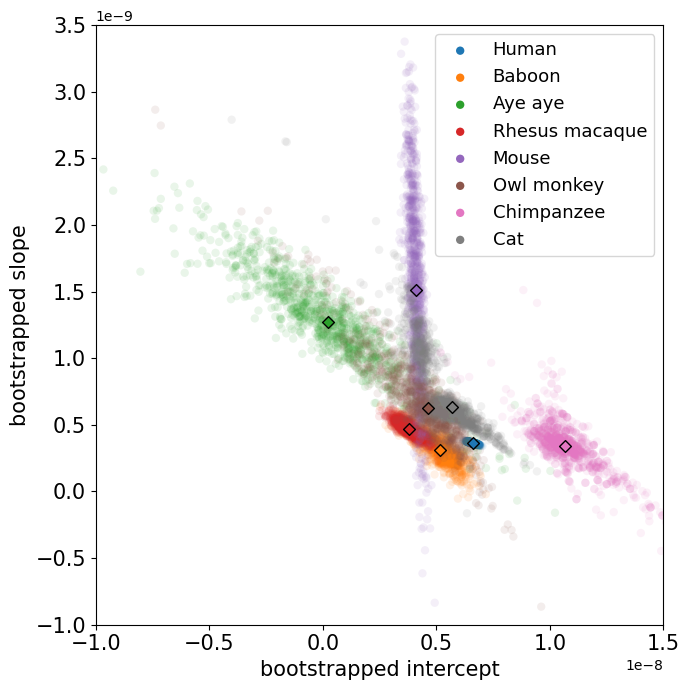

In [17]:
for use_default_alpha in [True, False]:
    df_wang_wang = load_df_for_species(use_default_alpha)
    save_figure = False if use_default_alpha is True else True
    plot_bootstrap = False if use_default_alpha is True else True
    num_bootstrap_main = 0 if use_default_alpha is True else 1000
    
    [_, point_estimates_wang_wang, df_wang_wang] = main_bootstrap(df_wang_wang, generation_time, age_of_puberty, num_bootstrap_iterations=num_bootstrap_main, plot_bootstrap=plot_bootstrap, save_figure=save_figure)

    df_ayeaye_versoza = load_versoza_aye_aye_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio["Aye_aye"])
    [_, point_estimate_ayeaye_versoza, df_versoza] = main_bootstrap(df_ayeaye_versoza, generation_time, age_of_puberty, num_bootstrap_iterations=0, plot_bootstrap=False)

    [_, df_baboon_wu] = load_baboon_human_wu_2020_data(age_of_puberty, use_default_alpha, paternal_maternal_ratio)
    [_, point_estimate_baboon_wu, df_wu] = main_bootstrap(df_baboon_wu, generation_time, age_of_puberty, num_bootstrap_iterations=0, plot_bootstrap=False)

    merged_point_estimates = group_point_estimates(point_estimates_wang_wang, point_estimate_ayeaye_versoza, point_estimate_baboon_wu)
    save_point_estimates_and_generation_time(merged_point_estimates, generation_time, use_default_alpha)
    df_regression = pd.concat([df_wang_wang, df_versoza, df_wu])
    alpha_str = "default_alpha" if use_default_alpha else "variable_alpha"
    df_regression.to_csv(f"output/individual_species_regression_result_{alpha_str}.csv")

In [18]:
def check_age_of_puberty_vs_recorded_age_of_reproduction(age_of_puberty, generation_time):
    table = []
    df = load_df_for_species(use_default_alpha=False)
    column_names = ["species", "age of puberty",  "generation time", "paternal age (min)", "maternal age (min)"]
    for s in df["species"].unique():
        df_s = df[df["species"] == s]
        paternal_age, maternal_age = df_s["paternal_age"], df_s["maternal_age"]
        paternal_age_min = np.min(paternal_age)
        maternal_age_min = np.min(maternal_age)
        table.append([s, f"{age_of_puberty[s]:.2f}", f"{generation_time[s]:.2f}", f"{paternal_age_min:.1f}", f"{maternal_age_min:.1f}"])
    print(tabulate(table, headers=column_names))

check_age_of_puberty_vs_recorded_age_of_reproduction(age_of_puberty, generation_time)

species           age of puberty    generation time    paternal age (min)    maternal age (min)
--------------  ----------------  -----------------  --------------------  --------------------
Human                      13                 29                     17                    16
Baboon                      5.4               10                      5.5                   5.3
Aye_aye                     3                  4                      8.5                   6.7
Rhesus_macaque              3.5                8                      3.4                   2.5
Mouse                       0.15               0.75                   0.2                   0.2
Owl_monkey                  1                  6.6                    2.8                   3
Chimpanzee                 14                 25                     14.7                  12.2
Cat                         0.5                3.8                    1.7                   1.4


In [19]:
def calculate_per_gen_mutation_rate(generation_time, age_of_puberty):
    df = pd.read_csv(f"output/individual_species_regression_result_variable_alpha.csv")
    # change column 'Unnamed: 0' to 'species'
    df = df.rename(columns={"Unnamed: 0": "species"})
    df["mu"] = df.apply(lambda x: x["intercept"] + x["slope"] * (generation_time[x["species"]] - age_of_puberty[x["species"]]), axis=1)
    print(df[["species", "intercept", "slope", "mu"]])
calculate_per_gen_mutation_rate(generation_time, age_of_puberty)

          species  intercept      slope         mu
0           Human  6.603e-09  3.632e-10  1.241e-08
1          Baboon  5.140e-09  3.146e-10  6.587e-09
2         Aye_aye  2.189e-10  1.273e-09  1.492e-09
3  Rhesus_macaque  3.785e-09  4.696e-10  5.898e-09
4           Mouse  4.079e-09  1.512e-09  4.986e-09
5      Owl_monkey  4.614e-09  6.275e-10  8.128e-09
6      Chimpanzee  1.068e-08  3.405e-10  1.443e-08
7             Cat  5.702e-09  6.365e-10  7.802e-09
8         Aye_aye  5.832e-10  8.482e-10  1.431e-09
9          Baboon  4.588e-09  1.806e-10  5.419e-09
